## 构建Two-Head网络对OCSVM进行改进

In [20]:
import pandas as pd
import os
import numpy as np
import tensorflow as tf
from tqdm import tqdm

# 设置tf GPU
# print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

1 Physical GPUs, 1 Logical GPUs


In [21]:
# 加载数据
def judge_1(time):
    time = time[:7].replace('-', '')
    if time <= '201803':
        return True
    else:
        return False

def judge_2(time):
    time = time[:7].replace('-', '')
    if time > '201803':
        return True
    else:
        return False

name2label = {'trojan':0, 'virus':1, 'worm':2, 'backdoor':3}
data_csv = pd.read_csv('../../csv/dataset_handled.csv')
data_2017 = data_csv[data_csv['first_seen'].apply(lambda x: x[:4]) == '2017']
data_2018 = data_csv[data_csv['first_seen'].apply(lambda x: x[:4]) == '2018']
data_2019 = data_csv[data_csv['first_seen'].apply(lambda x: x[:4]) == '2019']
    
data_2018_1 = data_2018[data_2018['first_seen'].apply(judge_1)]
data_2018_2 = data_2018[data_2018['first_seen'].apply(judge_2)]

data_train = data_2017.append(data_2018_1)
data_test_1 = data_2018_2
data_test_2 = data_2019
print(data_train.shape, data_test_1.shape, data_test_2.shape)

# 对测试集进行下采样
data_train = data_train.sample(frac=1, random_state=1).reset_index(drop=True)
data_test_1 = data_test_1.sample(frac=0.73, random_state=1).reset_index(drop=True)
data_test_2 = data_test_2.sample(frac=0.54, random_state=1).reset_index(drop=True)
print(data_train.shape, data_test_1.shape, data_test_2.shape)

(6929, 9) (2668, 9) (3878, 9)
(6929, 9) (1948, 9) (2094, 9)


In [22]:
from utils import *
data_path_1, labels_1 = path_loader(data_train)

In [23]:
# 创建dataset对象
def create_dataset(batch_size=128):
    batch_size = 128
    max_len = 200000
    db_train = tf.data.Dataset.from_generator(train_data_generator, args=[data_path_1, labels_1, 'train'], 
                                            output_types=(tf.float32, tf.int32), output_shapes=((None,), (4, )))
    db_val = tf.data.Dataset.from_generator(train_data_generator, args=[data_path_1, labels_1, 'val'], 
                                            output_types=(tf.float32, tf.int32), output_shapes=((None,), (4, )))

    db_train = db_train.batch(batch_size)
    db_val = db_val.batch(batch_size)

    return db_train, db_val

In [24]:
from malconv import *
from tensorflow.keras import Input, Model, regularizers
from tensorflow import keras

def train(db_train, db_val, epochs=7):
    model = get_twohead()

    # 创建训练过程
    optimizer = keras.optimizers.Adam()
    loss_sup = keras.losses.CategoricalCrossentropy(from_logits=True)
    metrics_train_1 = keras.metrics.CategoricalAccuracy()
    metrics_train_2 = keras.metrics.CategoricalAccuracy()
    metrics_val_1 = keras.metrics.CategoricalAccuracy()
    metrics_val_2 = keras.metrics.CategoricalAccuracy()

    loss_all = []
    acc_all = []

    for epoch in range(epochs):
        print('Start of epoch %d' % (epoch,))
        
        for step, (x_batch_train, y_batch_train) in enumerate(db_train):
            with tf.GradientTape() as tape:
                out1, out2 = model(x_batch_train)
                loss_value = loss_sup(y_batch_train, out1) + loss_sup(y_batch_train, out2)
            grads = tape.gradient(loss_value, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))
            metrics_train_1(y_batch_train, out1)
            metrics_train_2(y_batch_train, out2)
            
            if step % 10 == 0:
                print('Training loss (for one batch) at step %s: %s' % (step, float(loss_value)))
        loss_all.append(loss_value)
        train_acc_1 = metrics_train_1.result()
        train_acc_2 = metrics_train_2.result()
        print('Training acc over epoch: %s %s' % (float(train_acc_1), float(train_acc_2)))
        metrics_train_1.reset_states()
        metrics_train_2.reset_states()
        
        for x_batch_val, y_batch_val in db_val:
            val_out_1, val_out_2 = model(x_batch_val)
            metrics_val_1(y_batch_val, val_out_1)
            metrics_val_2(y_batch_val, val_out_2)
        
        val_acc_1 = metrics_val_1.result()
        val_acc_2 = metrics_val_2.result()
        acc_all.append(val_acc_1)
        print('Validation acc: %s %s' % (float(val_acc_1), float(val_acc_2))) 
        metrics_val_1.reset_states()
        metrics_val_2.reset_states()

    return model, loss_all, acc_all

In [7]:
db_train, db_val = create_dataset()

model_5, loss_all_5, acc_all_5 = train(db_train, db_val, epochs=5)
model_6, loss_all_6, acc_all_6 = train(db_train, db_val, epochs=6)
model_8, loss_all_8, acc_all_8 = train(db_train, db_val, epochs=8)
model_9, loss_all_9, acc_all_9 = train(db_train, db_val, epochs=9)
model_10, loss_all_10, acc_all_10 = train(db_train, db_val, epochs=10)


Start of epoch 0
Training loss (for one batch) at step 0: 2.774618625640869
Training loss (for one batch) at step 10: 2.3437929153442383
Training loss (for one batch) at step 20: 1.7641156911849976
Training loss (for one batch) at step 30: 0.9488663673400879
Training loss (for one batch) at step 40: 0.7221104502677917
Training loss (for one batch) at step 50: 0.42237386107444763
Training acc over epoch: 0.7445518970489502 0.7332948446273804
Validation acc: 0.9461683034896851 0.9435704946517944
Start of epoch 1
Training loss (for one batch) at step 0: 0.4214043915271759
Training loss (for one batch) at step 10: 0.3147301971912384
Training loss (for one batch) at step 20: 0.3701643943786621
Training loss (for one batch) at step 30: 0.19516366720199585
Training loss (for one batch) at step 40: 0.21578575670719147
Training loss (for one batch) at step 50: 0.10464834421873093
Training acc over epoch: 0.9608890414237976 0.9607446789741516
Validation acc: 0.9911963939666748 0.9926396012306213

In [11]:
model_5.save('../model/malconv_twohead_5.h5')
model_6.save('../model/malconv_twohead_6.h5')
model_8.save('../model/malconv_twohead_8.h5')
model_9.save('../model/malconv_twohead_9.h5')
model_10.save('../model/malconv_twohead_10.h5')

Start of epoch 0
Training loss (for one batch) at step 0: 2.7707319259643555
Training loss (for one batch) at step 10: 2.288975238800049
Training loss (for one batch) at step 20: 1.7674741744995117
Training loss (for one batch) at step 30: 0.9268186092376709
Training loss (for one batch) at step 40: 0.7155742049217224
Training loss (for one batch) at step 50: 0.4585139751434326
Training acc over epoch: 0.7877038717269897 0.7747149467468262
Validation acc: 0.9464569091796875 0.939385175704956
Start of epoch 1
Training loss (for one batch) at step 0: 0.40250688791275024
Training loss (for one batch) at step 10: 0.31400004029273987
Training loss (for one batch) at step 20: 0.3363119959831238
Training loss (for one batch) at step 30: 0.1800558865070343
Training loss (for one batch) at step 40: 0.20817694067955017
Training loss (for one batch) at step 50: 0.10030388832092285
Training acc over epoch: 0.9624765515327454 0.9597344398498535
Validation acc: 0.9913407564163208 0.9898975491523743


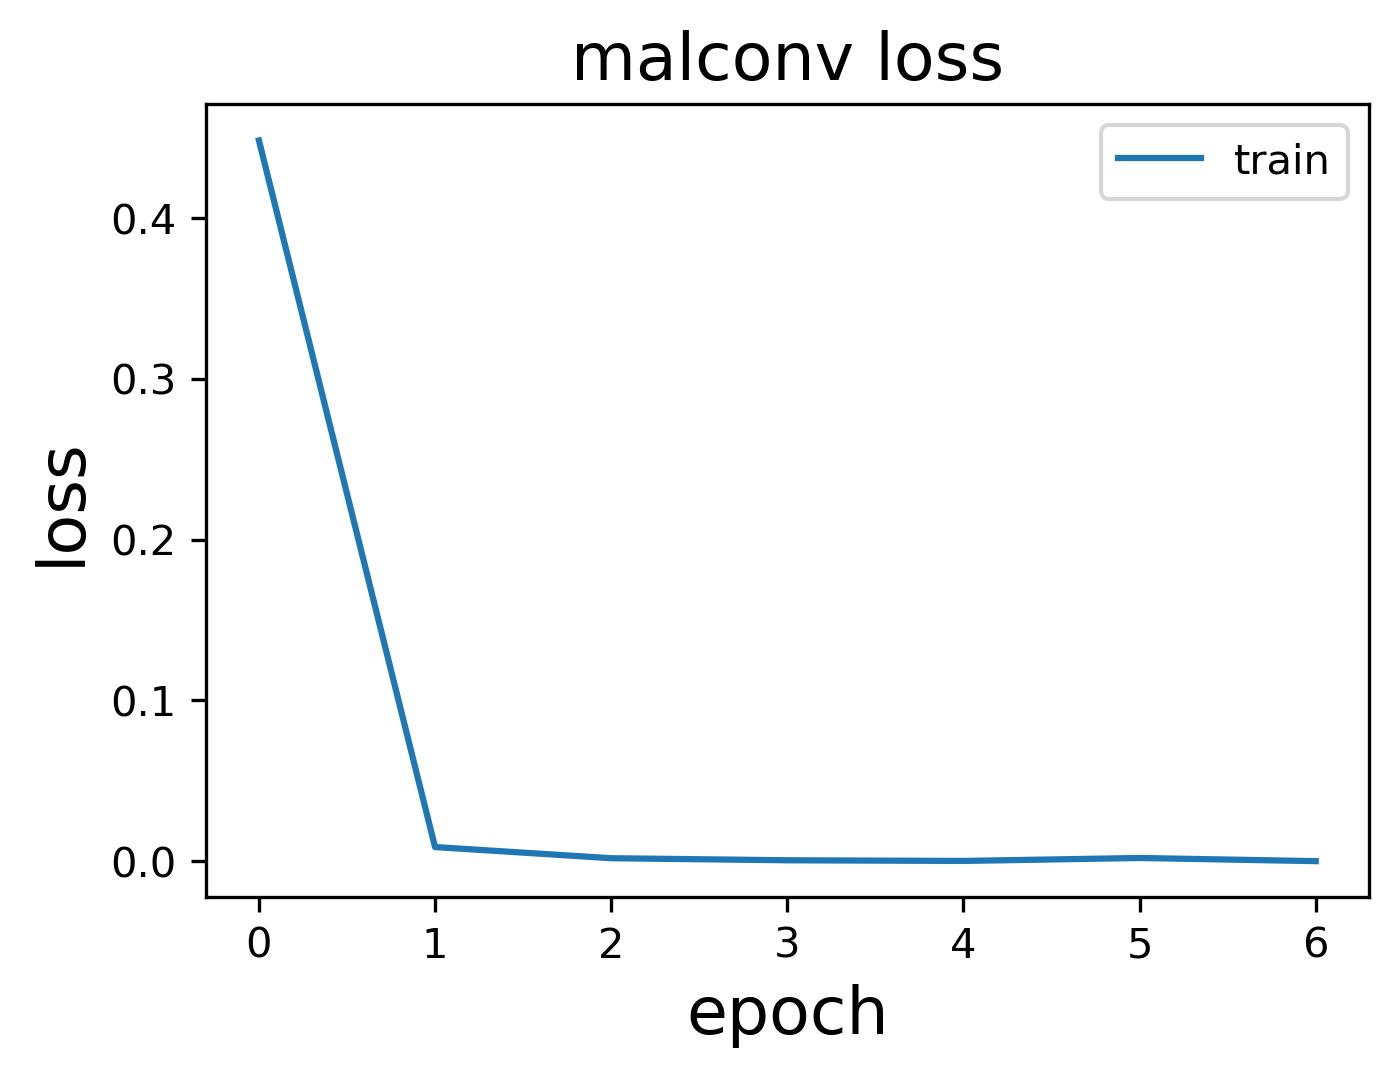

In [6]:
db_train, db_val = create_dataset()
model, loss_all, acc_all = train(db_train, db_val)

# loss 曲线
plt.figure(figsize=(5, 3.5), dpi=300)
plt.plot(loss_all, label="train")
plt.title("malconv loss", fontsize=16)
plt.ylabel("loss", fontsize=16)
plt.xlabel("epoch", fontsize=16)
plt.legend(["train"], loc="upper right")

plt.savefig("./figures/" + "twohead_loss_7.png")

In [7]:
# 保存模型
model.save('../model/malconv_twohead_7.h5')

55it [05:24,  5.91s/it]


<AxesSubplot:>

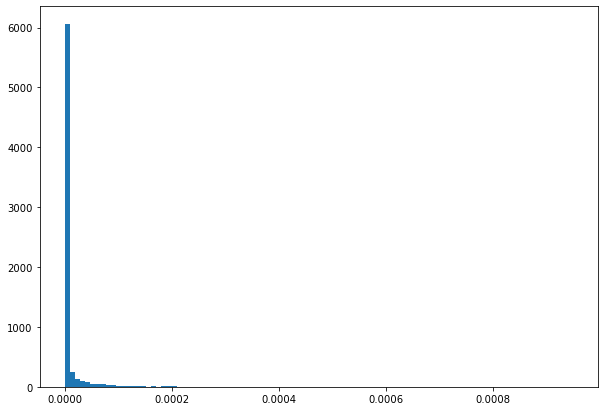

In [29]:
from malconv import *
from tensorflow.keras import Input, Model, regularizers
from tensorflow import keras
model = get_twohead()

db_train, db_val = create_dataset()
model.load_weights("../model/malconv_twohead_7.h5")
# 统计训练集上的discs

for step, (x_batch_train, y_batch_train) in tqdm(enumerate(db_train)):
    discs_tmp = get_discs(model, x_batch_train, y_batch_train)
    discs = discs_tmp if step == 0 else np.concatenate([discs, discs_tmp])

df = pd.DataFrame(discs)
df[0].hist(bins=100, grid=False, figsize=(10, 7))

In [27]:
len(discs)

6929

In [30]:
# discs_list = discs.tolist()
# discs_list.sort()
# discs_list[6097]

[1.0728836059570312e-05]

In [31]:
# discs_list[6236]

[1.5735626220703125e-05]

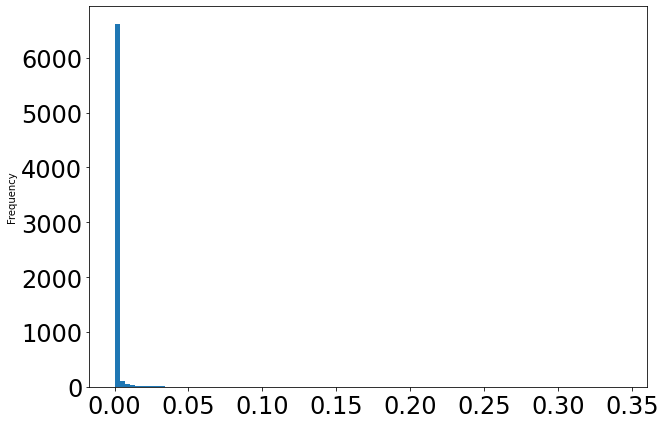

In [14]:
# tmpfig = df[0].plot.hist(bins=100, grid=False, figsize=(10, 7), fontsize=24)

# tmp_fi = tmpfig.get_figure()
# tmp_fi.savefig("histogram.png", dpi=300)

In [9]:
# 获取测试集的discs（roc相关的数据）
from utils import *
from malconv import *
from tensorflow.keras import Input, Model, regularizers
from tensorflow import keras
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np


def res_testset(data_test, model_twohead, model_split, test_label=2018):
    ood2label = {True: 0, False: 1}
    labels_test = data_test['id'].map(lambda x: ood2label[x])
    labels_test = labels_test.to_list()
    paths_test = data_test['name'].to_list()

    # 批量加载 防止内存过载
    batch_size = 100
    for idx in range(0, len(paths_test), batch_size):
        code_test_tmp = codes_loader(paths_test[idx: idx+batch_size])
        labels_test_tmp = np.array(labels_test[idx: idx+batch_size])
        discs_sub = get_discs(model_twohead, code_test_tmp, labels_test_tmp)
        discs = discs_sub if idx == 0 else np.concatenate((discs, discs_sub), axis=0)
    
    labels_test = np.array(labels_test)
    test_auc = metrics.roc_auc_score(labels_test, discs)
    print('Test AUROC: {:.3f}'.format(test_auc))
    plot_entropy(discs, labels_test, "entropy_distribution_" + test_label + ".png")
    
    # 确定异常检测阈值
    fpr, tpr, thresholds = roc_curve(labels_test, discs)
    roc_auc = auc(fpr, tpr)

    # for i in range(len(fpr)):
    #     if fpr[i] + tpr[i] >= 1:
    #         i = i - 1
    #         break
    # print(fpr[i])
    # score = thresholds[i]
    # print("score: ", score)

    # 约登指数确定
    index = np.argmax(tpr-fpr)
    print(f"fpr: {fpr[index]}")
    score = thresholds[index]
    print("threshold: ", score)

    bool_ = discs < score

    # 绘制roc曲线
    plt.figure(figsize=(5, 3.5), dpi=300)
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.plot(fpr[index], tpr[index], marker='o', color='r')
    plt.text(fpr[index], tpr[index], f"threshold: {score:.4f}")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC of two-head on ' + test_label + ' dataset (MalConv)')
    plt.legend(loc="lower right")
    plt.show()
    plt.savefig("./figures/" + "roc_malconv_" + test_label + "_7.png")

    labels_pre_id = data_test['label'].map(lambda x: name2label[x])
    labels_pre_id = np.array(labels_pre_id).reshape(-1, 1)
    labels_pre_id = labels_pre_id[bool_]
    paths_test = data_test['name'].to_list()

    bool_code = bool_.reshape(-1)

    # 分批预测
    batch_size = 200
    for idx in tqdm(range(0, len(paths_test), batch_size)):
        code_test_tmp = codes_loader(paths_test[idx: idx+batch_size])
        code_id_tmp = code_test_tmp[bool_code[idx: idx+batch_size]]
        y_pred_tmp = model_split.predict(code_id_tmp)
        y_pred_tmp = np.argmax(y_pred_tmp, axis=1)
        y_pred = y_pred_tmp if idx == 0 else np.concatenate((y_pred, y_pred_tmp), axis=0)

    target_names = {'trojan', 'virus', 'worm', 'backdoor'}
    print(classification_report(labels_pre_id, y_pred, target_names=target_names, digits=4))

    # 异常检测报告
    print("异常检测报告")
    two_pred = np.array(bool_)
    two_pred = ~two_pred
    two_pred = two_pred.astype('int64')
    ood2label = {True: 0, False: 1}
    label_id = np.array(data_test['id'].map(lambda x: ood2label[x]))
    print(classification_report(label_id, two_pred, digits=4))


Test AUROC: 0.908
fpr: 0.1343366778149387
threshold:  0.0030037165


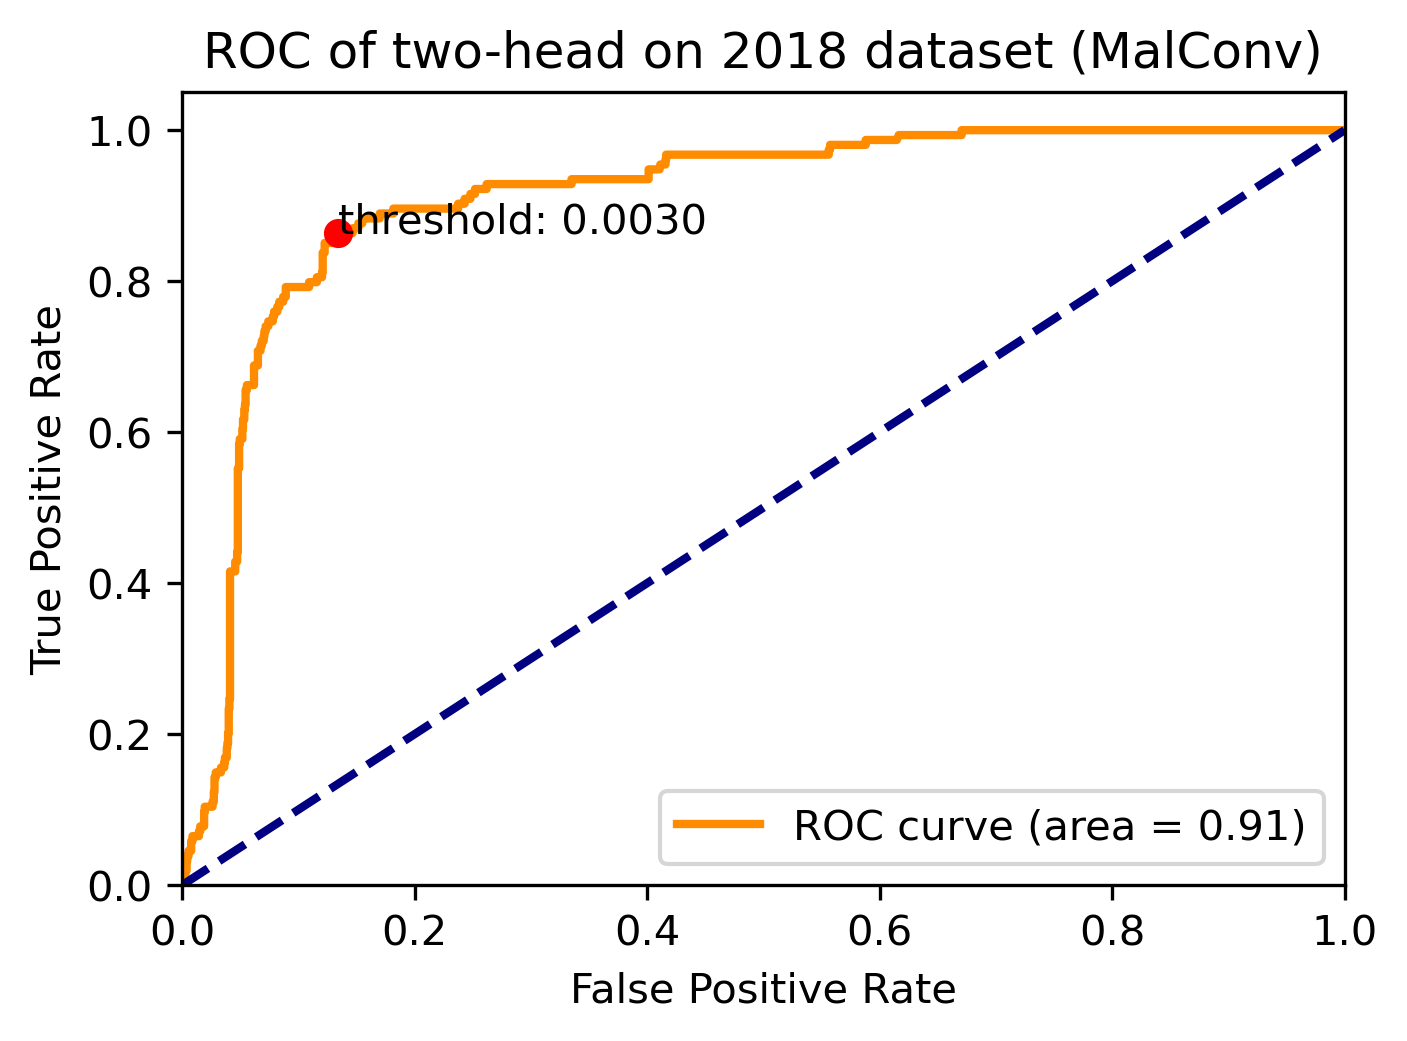

100%|██████████| 10/10 [00:59<00:00,  5.90s/it]


              precision    recall  f1-score   support

        worm     0.9661    1.0000    0.9828       570
      trojan     0.9979    0.9979    0.9979       473
    backdoor     1.0000    0.9424    0.9704       278
       virus     1.0000    0.9842    0.9920       253

    accuracy                         0.9867      1574
   macro avg     0.9910    0.9811    0.9858      1574
weighted avg     0.9871    0.9867    0.9866      1574

异常检测报告
              precision    recall  f1-score   support

           0     0.9867    0.8657    0.9222      1794
           1     0.3556    0.8636    0.5038       154

    accuracy                         0.8655      1948
   macro avg     0.6711    0.8646    0.7130      1948
weighted avg     0.9368    0.8655    0.8891      1948

Test AUROC: 0.878
fpr: 0.23097392229909527
threshold:  0.0048519373


<Figure size 432x288 with 0 Axes>

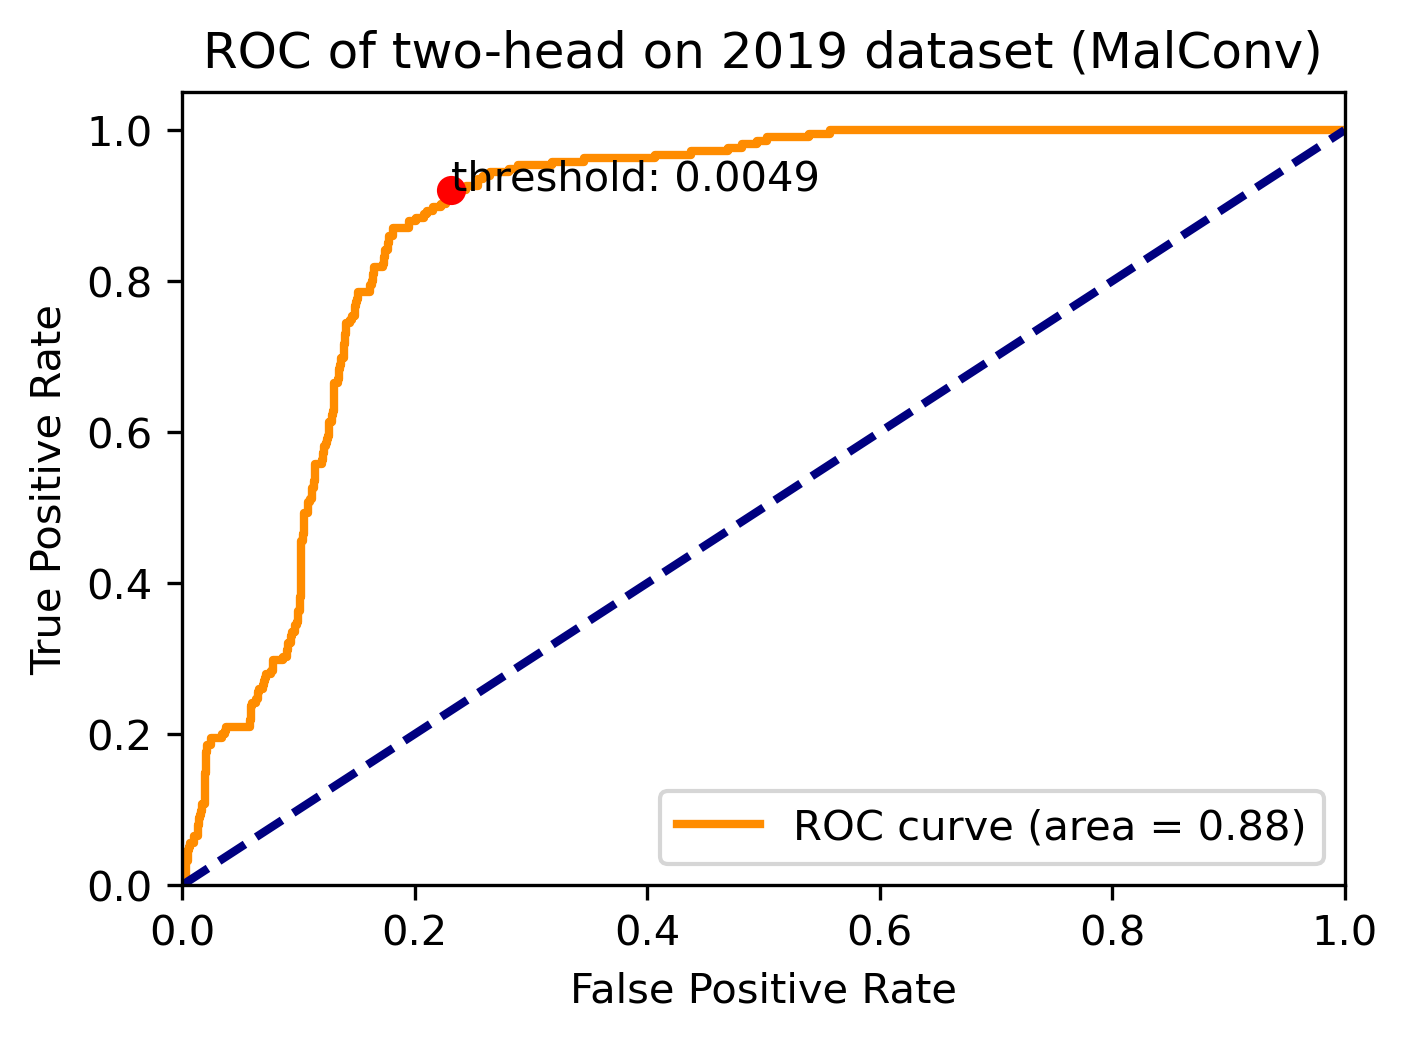

100%|██████████| 11/11 [01:05<00:00,  5.97s/it]

              precision    recall  f1-score   support

        worm     0.9753    0.9958    0.9854       475
      trojan     0.9971    0.9828    0.9899       349
    backdoor     1.0000    0.9888    0.9944       357
       virus     0.9857    0.9822    0.9840       281

    accuracy                         0.9884      1462
   macro avg     0.9895    0.9874    0.9884      1462
weighted avg     0.9885    0.9884    0.9884      1462

异常检测报告
              precision    recall  f1-score   support

           0     0.9884    0.7690    0.8650      1879
           1     0.3133    0.9209    0.4675       215

    accuracy                         0.7846      2094
   macro avg     0.6508    0.8450    0.6663      2094
weighted avg     0.9191    0.7846    0.8242      2094



<Figure size 432x288 with 0 Axes>

In [23]:
model_twohead = get_twohead()
model_twohead.load_weights('../model/malconv_twohead_7.h5')

model_split = keras.models.load_model('../model/malconv_split.h5')
data_test_1 = pd.read_csv('data_test_1.csv')
data_test_2 = pd.read_csv('data_test_2.csv')

res_testset(data_test=data_test_1, model_twohead=model_twohead, model_split=model_split, test_label="2018")
res_testset(data_test=data_test_2, model_twohead=model_twohead, model_split=model_split, test_label="2019")

## 进行参数微调并改进模型

In [11]:
# 自定义损失函数
from tensorflow.keras import backend as K
from tensorflow.keras import Input, Model, regularizers
from tensorflow import keras
from malconv import *
from utils import *

model = get_twohead()
class DiscrepancyLoss(keras.losses.Loss):
    def __init__(self, reduction=keras.losses.Reduction.NONE, 
                 from_logits=True, name='membership loss'):
        super().__init__(reduction=reduction, name=name)
    
    def call(self, out1, out2, m=0.3):
        out_1 = K.softmax(out1)
        out_2 = K.softmax(out2)     
        entropy_1 = -out_1 * K.log(out_1)
        entropy_2 = -out_2 * K.log(out_2)
        entropy_1 = K.mean(entropy_1, axis=1)
        entropy_2 = K.mean(entropy_2, axis=1) 
        
        return K.relu(m - K.mean(entropy_1 - entropy_2))

In [12]:
# 加载SVM预测数据
data_test_1 = pd.read_csv('data_test_1.csv')
data_test_unsup = data_test_1[data_test_1['ocsvm']!=0]
codes_unsup = data_test_unsup['name'].to_list()
print(len(codes_unsup))

408


In [13]:
# import importlib
# importlib.reload(utils)
# utils.test()

In [14]:
# 准备训练数据
batch_size = 64
sup_train = tf.data.Dataset.from_generator(svmdata_generator, args=[data_path_1, labels_1, 'train'], 
                                          output_types=(tf.float32, tf.int32), output_shapes=((None,), (4, )))
sup_train = sup_train.batch(batch_size)

sup_val = tf.data.Dataset.from_generator(svmdata_generator, args=[data_path_1, labels_1, 'val'], 
                                          output_types=(tf.float32, tf.int32), output_shapes=((None,), (4, )))
sup_val = sup_val.batch(batch_size)

unsup_train = tf.data.Dataset.from_generator(codes_generator, args=[codes_unsup], output_types=(tf.float32), output_shapes=((None,)))
unsup_train = unsup_train.batch(batch_size)

In [15]:
# 准备测试数据
data_test_1 = pd.read_csv('data_test_1.csv')
ood2label = {True: 0, False: 1}
labels_test_1 = data_test_1['id'].map(lambda x: ood2label[x])
labels_test_1 = labels_test_1.to_list()
paths_test_1 = data_test_1['name'].to_list()
# codes_test_1 = codes_loader(paths_test_1)
labels_test_1 = np.array(labels_test_1)

In [16]:
# 开始训练
import visdom
from tqdm import tqdm

model = get_twohead()
model.load_weights('../model/malconv_twohead.h5')
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
loss_sup = keras.losses.CategoricalCrossentropy(from_logits=True)
loss_unsup = DiscrepancyLoss()
train_acc_metric = keras.metrics.CategoricalAccuracy()
val_acc_metric = keras.metrics.CategoricalAccuracy()
vis = visdom.Visdom(server='http://localhost')

print('>> Fine-tune a Model.')
best_auc = 0.
num_epochs = 10
iters = 0
plot_data = {'X': [], 'Y': [], 'legend': ['Sup. Loss', 'Unsup. Loss', 'Tot. Loss']}
for epoch in range(num_epochs):

    for step, batch in enumerate(zip(sup_train, unsup_train)):
        
        (x_batch_train, y_batch_train), (x_batch_train_unsup) = batch
        print('Start of epoch %d step %d' % (epoch,step))
        with tf.GradientTape() as tape:
            out_1, out_2 = model(x_batch_train)
            loss_sup_value = loss_sup(y_batch_train, out_1) + loss_sup(y_batch_train, out_2)
            out_1, out_2 = model(x_batch_train_unsup)
            loss_unsup_value = loss_unsup(out_1, out_2)
            loss_value = loss_sup_value + loss_unsup_value
        grads = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        # 可视化
        if step % 2 == 0:
            
            loss_sup_value = loss_sup_value.numpy()
            loss_unsup_value = loss_unsup_value.numpy()
            loss_value = loss_value.numpy()
            
            plot_data['X'].append(iters)
            plot_data['Y'].append([
                loss_sup_value, loss_unsup_value, loss_value])
            vis.line(
                X=np.stack([np.array(plot_data['X'])] * len(plot_data['legend']), 1),
                Y=np.array(plot_data['Y']),
                opts={
                    'title': 'Loss over Time',
                    'legend': plot_data['legend'],
                    'xlabel': 'Iterations',
                    'ylabel': 'Loss',
                    'width': 900,
                    'height': 300,
                },
                win=2
            )
        iters += 1 
        
        # 使用test1数据集进行验证
        if step % 2 == 0:
            # 批量加载 防止内存过载
            batch_size = 20
            for idx in tqdm(range(0, len(paths_test_1), batch_size)):
                code_test_tmp = codes_loader(paths_test_1[idx: idx+batch_size])
                out_1_tmp, out_2_tmp = model.predict(code_test_tmp)
                out_1_tmp = keras.backend.softmax(out_1_tmp).numpy()
                out_2_tmp = keras.backend.softmax(out_2_tmp).numpy()

                entropy_1_tmp = np.max(out_1_tmp, axis=1)
                entropy_2_tmp = np.max(out_2_tmp, axis=1)

                discs_tmp = np.abs(entropy_1_tmp - entropy_2_tmp).reshape((-1, 1))
                discs = discs_tmp if idx == 0 else np.concatenate((discs, discs_tmp), axis=0)
        
            labels = np.array(labels_test_1)
            test_auc = metrics.roc_auc_score(labels, discs)
            print('Test AUROC: {:.3f}'.format(test_auc))
            if test_auc > best_auc:
                best_auc = test_auc
                model.save('../model/twohead_fine_tune.h5')

Setting up a new session...
Traceback (most recent call last):
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connection.py", line 169, in _new_conn
    conn = connection.create_connection(
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/util/connection.py", line 96, in create_connection
    raise err
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/util/connection.py", line 86, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connectionpool.py", line 699, in urlopen
    httplib_response = self._make_request(
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connectionpool.py", line 394, in _make_request
    conn.request(method, url, **ht

Exception in user code:
------------------------------------------------------------
>> Fine-tune a Model.
Start of epoch 0 step 0


Traceback (most recent call last):
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connection.py", line 169, in _new_conn
    conn = connection.create_connection(
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/util/connection.py", line 96, in create_connection
    raise err
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/util/connection.py", line 86, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connectionpool.py", line 699, in urlopen
    httplib_response = self._make_request(
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connectionpool.py", line 394, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/h

Exception in user code:
------------------------------------------------------------


100%|██████████| 98/98 [01:06<00:00,  1.48it/s]


Test AUROC: 0.936
Start of epoch 0 step 1
Start of epoch 0 step 2


Traceback (most recent call last):
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connection.py", line 169, in _new_conn
    conn = connection.create_connection(
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/util/connection.py", line 96, in create_connection
    raise err
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/util/connection.py", line 86, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connectionpool.py", line 699, in urlopen
    httplib_response = self._make_request(
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connectionpool.py", line 394, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/h

Exception in user code:
------------------------------------------------------------


100%|██████████| 98/98 [00:38<00:00,  2.53it/s]


Test AUROC: 0.948
Start of epoch 0 step 3
Start of epoch 0 step 4


Traceback (most recent call last):
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connection.py", line 169, in _new_conn
    conn = connection.create_connection(
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/util/connection.py", line 96, in create_connection
    raise err
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/util/connection.py", line 86, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connectionpool.py", line 699, in urlopen
    httplib_response = self._make_request(
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connectionpool.py", line 394, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/h

Exception in user code:
------------------------------------------------------------


100%|██████████| 98/98 [00:38<00:00,  2.55it/s]


Test AUROC: 0.953
Start of epoch 0 step 5
Start of epoch 0 step 6


Traceback (most recent call last):
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connection.py", line 169, in _new_conn
    conn = connection.create_connection(
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/util/connection.py", line 96, in create_connection
    raise err
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/util/connection.py", line 86, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connectionpool.py", line 699, in urlopen
    httplib_response = self._make_request(
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connectionpool.py", line 394, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/h

Exception in user code:
------------------------------------------------------------


100%|██████████| 98/98 [00:38<00:00,  2.53it/s]


Test AUROC: 0.952
Start of epoch 1 step 0


Traceback (most recent call last):
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connection.py", line 169, in _new_conn
    conn = connection.create_connection(
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/util/connection.py", line 96, in create_connection
    raise err
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/util/connection.py", line 86, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connectionpool.py", line 699, in urlopen
    httplib_response = self._make_request(
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connectionpool.py", line 394, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/h

Exception in user code:
------------------------------------------------------------


100%|██████████| 98/98 [00:39<00:00,  2.50it/s]


Test AUROC: 0.950
Start of epoch 1 step 1
Start of epoch 1 step 2


Traceback (most recent call last):
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connection.py", line 169, in _new_conn
    conn = connection.create_connection(
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/util/connection.py", line 96, in create_connection
    raise err
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/util/connection.py", line 86, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connectionpool.py", line 699, in urlopen
    httplib_response = self._make_request(
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connectionpool.py", line 394, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/h

Exception in user code:
------------------------------------------------------------


100%|██████████| 98/98 [00:39<00:00,  2.51it/s]


Test AUROC: 0.949
Start of epoch 1 step 3
Start of epoch 1 step 4


Traceback (most recent call last):
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connection.py", line 169, in _new_conn
    conn = connection.create_connection(
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/util/connection.py", line 96, in create_connection
    raise err
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/util/connection.py", line 86, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connectionpool.py", line 699, in urlopen
    httplib_response = self._make_request(
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connectionpool.py", line 394, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/h

Exception in user code:
------------------------------------------------------------


100%|██████████| 98/98 [00:39<00:00,  2.50it/s]


Test AUROC: 0.952
Start of epoch 1 step 5
Start of epoch 1 step 6


Traceback (most recent call last):
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connection.py", line 169, in _new_conn
    conn = connection.create_connection(
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/util/connection.py", line 96, in create_connection
    raise err
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/util/connection.py", line 86, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connectionpool.py", line 699, in urlopen
    httplib_response = self._make_request(
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connectionpool.py", line 394, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/h

Exception in user code:
------------------------------------------------------------


100%|██████████| 98/98 [00:39<00:00,  2.51it/s]


Test AUROC: 0.955
Start of epoch 2 step 0


Traceback (most recent call last):
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connection.py", line 169, in _new_conn
    conn = connection.create_connection(
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/util/connection.py", line 96, in create_connection
    raise err
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/util/connection.py", line 86, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connectionpool.py", line 699, in urlopen
    httplib_response = self._make_request(
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connectionpool.py", line 394, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/h

Exception in user code:
------------------------------------------------------------


100%|██████████| 98/98 [00:38<00:00,  2.52it/s]


Test AUROC: 0.956
Start of epoch 2 step 1
Start of epoch 2 step 2


Traceback (most recent call last):
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connection.py", line 169, in _new_conn
    conn = connection.create_connection(
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/util/connection.py", line 96, in create_connection
    raise err
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/util/connection.py", line 86, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connectionpool.py", line 699, in urlopen
    httplib_response = self._make_request(
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connectionpool.py", line 394, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/h

Exception in user code:
------------------------------------------------------------


100%|██████████| 98/98 [00:39<00:00,  2.51it/s]


Test AUROC: 0.957
Start of epoch 2 step 3
Start of epoch 2 step 4


Traceback (most recent call last):
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connection.py", line 169, in _new_conn
    conn = connection.create_connection(
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/util/connection.py", line 96, in create_connection
    raise err
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/util/connection.py", line 86, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connectionpool.py", line 699, in urlopen
    httplib_response = self._make_request(
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connectionpool.py", line 394, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/h

Exception in user code:
------------------------------------------------------------


100%|██████████| 98/98 [00:38<00:00,  2.52it/s]


Test AUROC: 0.957
Start of epoch 2 step 5
Start of epoch 2 step 6


Traceback (most recent call last):
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connection.py", line 169, in _new_conn
    conn = connection.create_connection(
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/util/connection.py", line 96, in create_connection
    raise err
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/util/connection.py", line 86, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connectionpool.py", line 699, in urlopen
    httplib_response = self._make_request(
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connectionpool.py", line 394, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/h

Exception in user code:
------------------------------------------------------------


100%|██████████| 98/98 [00:38<00:00,  2.52it/s]


Test AUROC: 0.958
Start of epoch 3 step 0


Traceback (most recent call last):
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connection.py", line 169, in _new_conn
    conn = connection.create_connection(
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/util/connection.py", line 96, in create_connection
    raise err
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/util/connection.py", line 86, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connectionpool.py", line 699, in urlopen
    httplib_response = self._make_request(
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connectionpool.py", line 394, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/h

Exception in user code:
------------------------------------------------------------


100%|██████████| 98/98 [00:38<00:00,  2.52it/s]


Test AUROC: 0.958
Start of epoch 3 step 1
Start of epoch 3 step 2


Traceback (most recent call last):
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connection.py", line 169, in _new_conn
    conn = connection.create_connection(
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/util/connection.py", line 96, in create_connection
    raise err
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/util/connection.py", line 86, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connectionpool.py", line 699, in urlopen
    httplib_response = self._make_request(
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connectionpool.py", line 394, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/h

Exception in user code:
------------------------------------------------------------


100%|██████████| 98/98 [00:38<00:00,  2.52it/s]


Test AUROC: 0.960
Start of epoch 3 step 3
Start of epoch 3 step 4


Traceback (most recent call last):
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connection.py", line 169, in _new_conn
    conn = connection.create_connection(
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/util/connection.py", line 96, in create_connection
    raise err
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/util/connection.py", line 86, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connectionpool.py", line 699, in urlopen
    httplib_response = self._make_request(
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connectionpool.py", line 394, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/h

Exception in user code:
------------------------------------------------------------


100%|██████████| 98/98 [00:41<00:00,  2.37it/s]


Test AUROC: 0.959
Start of epoch 3 step 5
Start of epoch 3 step 6


Traceback (most recent call last):
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connection.py", line 169, in _new_conn
    conn = connection.create_connection(
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/util/connection.py", line 96, in create_connection
    raise err
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/util/connection.py", line 86, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connectionpool.py", line 699, in urlopen
    httplib_response = self._make_request(
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connectionpool.py", line 394, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/h

Exception in user code:
------------------------------------------------------------


100%|██████████| 98/98 [00:38<00:00,  2.52it/s]


Test AUROC: 0.957
Start of epoch 4 step 0


Traceback (most recent call last):
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connection.py", line 169, in _new_conn
    conn = connection.create_connection(
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/util/connection.py", line 96, in create_connection
    raise err
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/util/connection.py", line 86, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connectionpool.py", line 699, in urlopen
    httplib_response = self._make_request(
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connectionpool.py", line 394, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/h

Exception in user code:
------------------------------------------------------------


100%|██████████| 98/98 [00:39<00:00,  2.51it/s]


Test AUROC: 0.955
Start of epoch 4 step 1
Start of epoch 4 step 2


Traceback (most recent call last):
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connection.py", line 169, in _new_conn
    conn = connection.create_connection(
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/util/connection.py", line 96, in create_connection
    raise err
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/util/connection.py", line 86, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connectionpool.py", line 699, in urlopen
    httplib_response = self._make_request(
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connectionpool.py", line 394, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/h

Exception in user code:
------------------------------------------------------------


100%|██████████| 98/98 [00:39<00:00,  2.51it/s]


Test AUROC: 0.955
Start of epoch 4 step 3
Start of epoch 4 step 4


Traceback (most recent call last):
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connection.py", line 169, in _new_conn
    conn = connection.create_connection(
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/util/connection.py", line 96, in create_connection
    raise err
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/util/connection.py", line 86, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connectionpool.py", line 699, in urlopen
    httplib_response = self._make_request(
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connectionpool.py", line 394, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/h

Exception in user code:
------------------------------------------------------------


100%|██████████| 98/98 [00:38<00:00,  2.52it/s]


Test AUROC: 0.954
Start of epoch 4 step 5
Start of epoch 4 step 6


Traceback (most recent call last):
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connection.py", line 169, in _new_conn
    conn = connection.create_connection(
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/util/connection.py", line 96, in create_connection
    raise err
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/util/connection.py", line 86, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connectionpool.py", line 699, in urlopen
    httplib_response = self._make_request(
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connectionpool.py", line 394, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/h

Exception in user code:
------------------------------------------------------------


100%|██████████| 98/98 [00:38<00:00,  2.52it/s]


Test AUROC: 0.954
Start of epoch 5 step 0


Traceback (most recent call last):
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connection.py", line 169, in _new_conn
    conn = connection.create_connection(
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/util/connection.py", line 96, in create_connection
    raise err
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/util/connection.py", line 86, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connectionpool.py", line 699, in urlopen
    httplib_response = self._make_request(
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connectionpool.py", line 394, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/h

Exception in user code:
------------------------------------------------------------


100%|██████████| 98/98 [00:39<00:00,  2.51it/s]


Test AUROC: 0.954
Start of epoch 5 step 1
Start of epoch 5 step 2


Traceback (most recent call last):
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connection.py", line 169, in _new_conn
    conn = connection.create_connection(
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/util/connection.py", line 96, in create_connection
    raise err
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/util/connection.py", line 86, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connectionpool.py", line 699, in urlopen
    httplib_response = self._make_request(
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connectionpool.py", line 394, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/h

Exception in user code:
------------------------------------------------------------


100%|██████████| 98/98 [00:39<00:00,  2.51it/s]


Test AUROC: 0.954
Start of epoch 5 step 3
Start of epoch 5 step 4


Traceback (most recent call last):
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connection.py", line 169, in _new_conn
    conn = connection.create_connection(
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/util/connection.py", line 96, in create_connection
    raise err
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/util/connection.py", line 86, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connectionpool.py", line 699, in urlopen
    httplib_response = self._make_request(
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connectionpool.py", line 394, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/h

Exception in user code:
------------------------------------------------------------


100%|██████████| 98/98 [00:39<00:00,  2.51it/s]


Test AUROC: 0.954
Start of epoch 5 step 5
Start of epoch 5 step 6


Traceback (most recent call last):
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connection.py", line 169, in _new_conn
    conn = connection.create_connection(
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/util/connection.py", line 96, in create_connection
    raise err
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/util/connection.py", line 86, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connectionpool.py", line 699, in urlopen
    httplib_response = self._make_request(
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connectionpool.py", line 394, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/h

Exception in user code:
------------------------------------------------------------


100%|██████████| 98/98 [00:39<00:00,  2.51it/s]


Test AUROC: 0.953
Start of epoch 6 step 0


Traceback (most recent call last):
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connection.py", line 169, in _new_conn
    conn = connection.create_connection(
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/util/connection.py", line 96, in create_connection
    raise err
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/util/connection.py", line 86, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connectionpool.py", line 699, in urlopen
    httplib_response = self._make_request(
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connectionpool.py", line 394, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/h

Exception in user code:
------------------------------------------------------------


100%|██████████| 98/98 [00:38<00:00,  2.52it/s]


Test AUROC: 0.953
Start of epoch 6 step 1
Start of epoch 6 step 2


Traceback (most recent call last):
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connection.py", line 169, in _new_conn
    conn = connection.create_connection(
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/util/connection.py", line 96, in create_connection
    raise err
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/util/connection.py", line 86, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connectionpool.py", line 699, in urlopen
    httplib_response = self._make_request(
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connectionpool.py", line 394, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/h

Exception in user code:
------------------------------------------------------------


100%|██████████| 98/98 [00:40<00:00,  2.40it/s]


Test AUROC: 0.954
Start of epoch 6 step 3
Start of epoch 6 step 4


Traceback (most recent call last):
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connection.py", line 169, in _new_conn
    conn = connection.create_connection(
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/util/connection.py", line 96, in create_connection
    raise err
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/util/connection.py", line 86, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connectionpool.py", line 699, in urlopen
    httplib_response = self._make_request(
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connectionpool.py", line 394, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/h

Exception in user code:
------------------------------------------------------------


100%|██████████| 98/98 [00:39<00:00,  2.51it/s]


Test AUROC: 0.955
Start of epoch 6 step 5
Start of epoch 6 step 6


Traceback (most recent call last):
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connection.py", line 169, in _new_conn
    conn = connection.create_connection(
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/util/connection.py", line 96, in create_connection
    raise err
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/util/connection.py", line 86, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connectionpool.py", line 699, in urlopen
    httplib_response = self._make_request(
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connectionpool.py", line 394, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/h

Exception in user code:
------------------------------------------------------------


100%|██████████| 98/98 [00:39<00:00,  2.51it/s]


Test AUROC: 0.955
Start of epoch 7 step 0


Traceback (most recent call last):
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connection.py", line 169, in _new_conn
    conn = connection.create_connection(
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/util/connection.py", line 96, in create_connection
    raise err
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/util/connection.py", line 86, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connectionpool.py", line 699, in urlopen
    httplib_response = self._make_request(
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connectionpool.py", line 394, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/h

Exception in user code:
------------------------------------------------------------


100%|██████████| 98/98 [00:39<00:00,  2.50it/s]


Test AUROC: 0.955
Start of epoch 7 step 1
Start of epoch 7 step 2


Traceback (most recent call last):
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connection.py", line 169, in _new_conn
    conn = connection.create_connection(
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/util/connection.py", line 96, in create_connection
    raise err
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/util/connection.py", line 86, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connectionpool.py", line 699, in urlopen
    httplib_response = self._make_request(
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connectionpool.py", line 394, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/h

Exception in user code:
------------------------------------------------------------


100%|██████████| 98/98 [00:38<00:00,  2.52it/s]


Test AUROC: 0.955
Start of epoch 7 step 3
Start of epoch 7 step 4


Traceback (most recent call last):
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connection.py", line 169, in _new_conn
    conn = connection.create_connection(
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/util/connection.py", line 96, in create_connection
    raise err
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/util/connection.py", line 86, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connectionpool.py", line 699, in urlopen
    httplib_response = self._make_request(
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connectionpool.py", line 394, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/h

Exception in user code:
------------------------------------------------------------


100%|██████████| 98/98 [00:38<00:00,  2.52it/s]


Test AUROC: 0.954
Start of epoch 7 step 5
Start of epoch 7 step 6


Traceback (most recent call last):
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connection.py", line 169, in _new_conn
    conn = connection.create_connection(
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/util/connection.py", line 96, in create_connection
    raise err
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/util/connection.py", line 86, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connectionpool.py", line 699, in urlopen
    httplib_response = self._make_request(
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connectionpool.py", line 394, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/h

Exception in user code:
------------------------------------------------------------


100%|██████████| 98/98 [00:38<00:00,  2.52it/s]


Test AUROC: 0.955
Start of epoch 8 step 0


Traceback (most recent call last):
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connection.py", line 169, in _new_conn
    conn = connection.create_connection(
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/util/connection.py", line 96, in create_connection
    raise err
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/util/connection.py", line 86, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connectionpool.py", line 699, in urlopen
    httplib_response = self._make_request(
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connectionpool.py", line 394, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/h

Exception in user code:
------------------------------------------------------------


100%|██████████| 98/98 [00:38<00:00,  2.53it/s]


Test AUROC: 0.955
Start of epoch 8 step 1
Start of epoch 8 step 2


Traceback (most recent call last):
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connection.py", line 169, in _new_conn
    conn = connection.create_connection(
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/util/connection.py", line 96, in create_connection
    raise err
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/util/connection.py", line 86, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connectionpool.py", line 699, in urlopen
    httplib_response = self._make_request(
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connectionpool.py", line 394, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/h

Exception in user code:
------------------------------------------------------------


100%|██████████| 98/98 [00:42<00:00,  2.30it/s]


Test AUROC: 0.955
Start of epoch 8 step 3
Start of epoch 8 step 4


Traceback (most recent call last):
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connection.py", line 169, in _new_conn
    conn = connection.create_connection(
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/util/connection.py", line 96, in create_connection
    raise err
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/util/connection.py", line 86, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connectionpool.py", line 699, in urlopen
    httplib_response = self._make_request(
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connectionpool.py", line 394, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/h

Exception in user code:
------------------------------------------------------------


100%|██████████| 98/98 [00:39<00:00,  2.47it/s]


Test AUROC: 0.954
Start of epoch 8 step 5
Start of epoch 8 step 6


Traceback (most recent call last):
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connection.py", line 169, in _new_conn
    conn = connection.create_connection(
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/util/connection.py", line 96, in create_connection
    raise err
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/util/connection.py", line 86, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connectionpool.py", line 699, in urlopen
    httplib_response = self._make_request(
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connectionpool.py", line 394, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/h

Exception in user code:
------------------------------------------------------------


100%|██████████| 98/98 [00:43<00:00,  2.26it/s]


Test AUROC: 0.954
Start of epoch 9 step 0


Traceback (most recent call last):
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connection.py", line 169, in _new_conn
    conn = connection.create_connection(
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/util/connection.py", line 96, in create_connection
    raise err
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/util/connection.py", line 86, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connectionpool.py", line 699, in urlopen
    httplib_response = self._make_request(
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connectionpool.py", line 394, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/h

Exception in user code:
------------------------------------------------------------


100%|██████████| 98/98 [00:40<00:00,  2.44it/s]


Test AUROC: 0.955
Start of epoch 9 step 1
Start of epoch 9 step 2


Traceback (most recent call last):
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connection.py", line 169, in _new_conn
    conn = connection.create_connection(
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/util/connection.py", line 96, in create_connection
    raise err
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/util/connection.py", line 86, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connectionpool.py", line 699, in urlopen
    httplib_response = self._make_request(
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connectionpool.py", line 394, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/h

Exception in user code:
------------------------------------------------------------


100%|██████████| 98/98 [00:41<00:00,  2.37it/s]


Test AUROC: 0.953
Start of epoch 9 step 3
Start of epoch 9 step 4


Traceback (most recent call last):
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connection.py", line 169, in _new_conn
    conn = connection.create_connection(
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/util/connection.py", line 96, in create_connection
    raise err
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/util/connection.py", line 86, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connectionpool.py", line 699, in urlopen
    httplib_response = self._make_request(
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connectionpool.py", line 394, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/h

Exception in user code:
------------------------------------------------------------


100%|██████████| 98/98 [00:39<00:00,  2.50it/s]


Test AUROC: 0.951
Start of epoch 9 step 5
Start of epoch 9 step 6


Traceback (most recent call last):
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connection.py", line 169, in _new_conn
    conn = connection.create_connection(
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/util/connection.py", line 96, in create_connection
    raise err
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/util/connection.py", line 86, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connectionpool.py", line 699, in urlopen
    httplib_response = self._make_request(
  File "/home/libyc/anaconda3/envs/tf2-gpu/lib/python3.8/site-packages/urllib3/connectionpool.py", line 394, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/h

Exception in user code:
------------------------------------------------------------


100%|██████████| 98/98 [00:39<00:00,  2.49it/s]


Test AUROC: 0.951


In [17]:
# model.load_weights('../model/twohead_fine_tune.h5')

# from sklearn import metrics
# from utils import *
# auc_res, discs = get_auc(model, codes_test_1, labels_test_1)
# print('Final AUROC: {:.3f}'.format(auc_res))
# plot_entropy(discs, labels_test_1, 'entropy_distribution.png')

In [18]:
# 对第一个测试集进行测试
from sklearn import metrics
from tqdm import tqdm

model.load_weights('../model/twohead_fine_tune.h5')

data_test_1 = pd.read_csv('data_test_1.csv')
ood2label = {True: 0, False: 1}
labels_test_1 = data_test_1['id'].map(lambda x: ood2label[x])
labels_test_1 = labels_test_1.to_list()
paths_test_1 = data_test_1['name'].to_list()

# 批量加载 防止内存过载
batch_size = 200
for idx in tqdm(range(0, len(paths_test_1), batch_size)):
    code_test_tmp = codes_loader(paths_test_1[idx: idx+batch_size])
    labels_test_tmp = np.array(labels_test_1[idx: idx+batch_size])
    discs_sub = get_discs(model, code_test_tmp, labels_test_tmp)
    discs = discs_sub if idx == 0 else np.concatenate((discs, discs_sub), axis=0)

labels_test_1 = np.array(labels_test_1)
test_auc = metrics.roc_auc_score(labels_test_1, discs)
print('Test AUROC: {:.3f}'.format(test_auc))
plot_entropy(discs, labels_test_1, 'entropy_distribution_1_best.png')

100%|██████████| 10/10 [00:37<00:00,  3.78s/it]


Test AUROC: 0.960


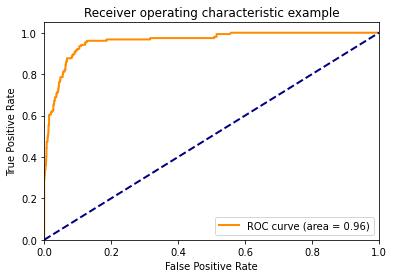

127
0.0037809014
0.12764771460423635


In [19]:
fpr, tpr, thresholds = roc_curve(labels_test_1, discs)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

index = np.argmax(tpr-fpr)
print(index)
print(thresholds[index])
print(fpr[index])

In [20]:
# from sklearn.metrics import roc_curve, auc
# import matplotlib.pyplot as plt

# fpr, tpr, thresholds = roc_curve(labels_test_1, discs)
# roc_auc = auc(fpr, tpr)
# for i in range(len(fpr)):
#     if fpr[i] + tpr[i] >= 1:
#         i = i - 1
#         break
# print(fpr[i])

# # 画图，只需要plt.plot(fpr,tpr),变量roc_auc只是记录auc的值，通过auc()函数能计算出来

# p1 = plt.figure(figsize=(4, 2.5),dpi=400)
# plt.plot(fpr, tpr, lw=1, label='ROC')
# # 画对角线
# plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

# plt.xlim([-0.05, 1.05])
# plt.ylim([-0.05, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic')
# plt.legend(loc="lower right")
# plt.savefig('./figures/twohead_roc.png')

# print(thresholds[i])
pred = discs>thresholds[index]
pred = pred.astype(int)
from sklearn.metrics import accuracy_score
accuracy_score(labels_test_1, pred)

0.8788501026694046

In [21]:
from sklearn.metrics import classification_report

labels_pre_id = data_test_1['label'].map(lambda x: name2label[x])
labels_pre_id = np.array(labels_pre_id).reshape(-1, 1)
labels_pre_id = labels_pre_id[discs<thresholds[index]]

model_pre = keras.models.load_model('../model/malconv_split.h5')
bool_code = discs<thresholds[index]
bool_code = bool_code.reshape(-1)
# print(type(bool_code), bool_code)


# 分批预测
batch_size = 200
for idx in tqdm(range(0, len(paths_test_1), batch_size)):
    code_test_tmp = codes_loader(paths_test_1[idx: idx+batch_size])
    code_id_tmp = code_test_tmp[bool_code[idx: idx+batch_size]]
    y_pred_tmp = model_pre.predict(code_id_tmp)
    y_pred_tmp = np.argmax(y_pred_tmp, axis=1)
    y_pred = y_pred_tmp if idx == 0 else np.concatenate((y_pred, y_pred_tmp), axis=0)

# codes_pre_id = codes_test_1[bool_code.reshape(-1)]
# y_pred = model_pre.predict(codes_pre_id)
# y_pred = np.argmax(y_pred, 1)
target_names = {'trojan', 'virus', 'worm', 'backdoor'}
print(classification_report(labels_pre_id, y_pred, target_names=target_names, digits=4))

100%|██████████| 10/10 [00:36<00:00,  3.68s/it]

              precision    recall  f1-score   support

        worm     0.9892    1.0000    0.9946       549
      trojan     1.0000    0.9979    0.9990       487
    backdoor     1.0000    0.9811    0.9905       265
       virus     1.0000    1.0000    1.0000       270

    accuracy                         0.9962      1571
   macro avg     0.9973    0.9948    0.9960      1571
weighted avg     0.9962    0.9962    0.9962      1571



In [22]:
print(thresholds[i])

NameError: name 'i' is not defined

In [ ]:
print(classification_report(labels_test_1, pred, digits=4))

              precision    recall  f1-score   support

           0     0.9881    0.8804    0.9312      1790
           1     0.3938    0.8797    0.5440       158

    accuracy                         0.8804      1948
   macro avg     0.6909    0.8801    0.7376      1948
weighted avg     0.9399    0.8804    0.8998      1948



In [ ]:
# 对第二个子集进行测试
from sklearn import metrics
from tqdm import tqdm

model.load_weights('../model/twohead_best.h5')

data_test_2 = pd.read_csv('data_test_2.csv')
ood2label = {True: 0, False: 1}
labels_test_2 = data_test_2['id'].map(lambda x: ood2label[x])
labels_test_2 = labels_test_2.to_list()
paths_test_2 = data_test_2['name'].to_list()

# 批量加载 防止内存过载
batch_size = 200
for idx in tqdm(range(0, len(paths_test_2), batch_size)):
    code_test_tmp = codes_loader(paths_test_2[idx: idx+batch_size])
    labels_test_tmp = np.array(labels_test_2[idx: idx+batch_size])
    discs_sub = get_discs(model, code_test_tmp, labels_test_tmp)
    discs = discs_sub if idx == 0 else np.concatenate((discs, discs_sub), axis=0)

labels_test_2 = np.array(labels_test_2)
test_auc = metrics.roc_auc_score(labels_test_2, discs)
print('Test AUROC: {:.3f}'.format(test_auc))
plot_entropy(discs, labels_test_2, 'entropy_distribution_2_best.png')

100%|██████████| 11/11 [01:50<00:00, 10.07s/it]
Test AUROC: 0.865


0.23474663908996898


0.7655205348615091

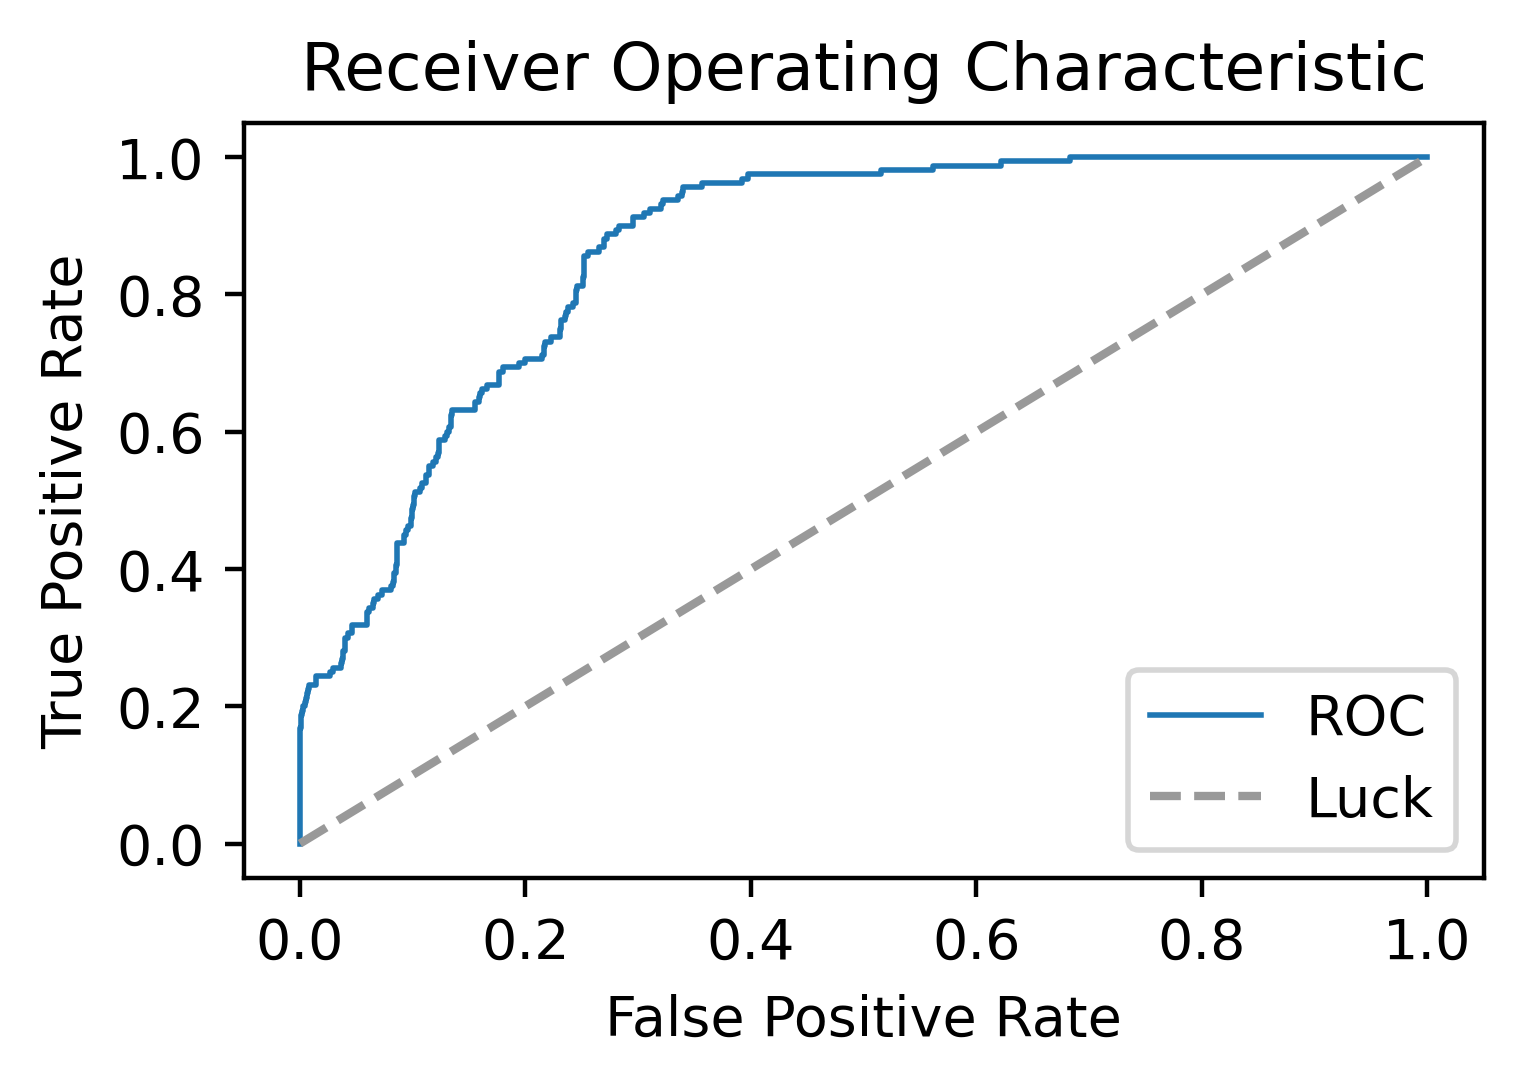

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(labels_test_2, discs)
roc_auc = auc(fpr, tpr)
for i in range(len(fpr)):
    if fpr[i] + tpr[i] >= 1:
        i = i - 1
        break
print(fpr[i])

# 画图，只需要plt.plot(fpr,tpr),变量roc_auc只是记录auc的值，通过auc()函数能计算出来
p1 = plt.figure(figsize=(4, 2.5),dpi=400)
plt.plot(fpr, tpr, lw=1, label='ROC')
# 画对角线
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('./figures/twohead_roc_2.png')

pred = discs>thresholds[i]
pred = pred.astype(int)
from sklearn.metrics import accuracy_score
accuracy_score(labels_test_2, pred)

In [ ]:
from sklearn.metrics import classification_report

labels_pre_id = data_test_2['label'].map(lambda x: name2label[x])
labels_pre_id = np.array(labels_pre_id).reshape(-1, 1)
labels_pre_id = labels_pre_id[discs<thresholds[i]]

model_pre = keras.models.load_model('../model/malconv_split.h5')
bool_code = discs<thresholds[i]
bool_code = bool_code.reshape(-1)
# print(type(bool_code), bool_code)


# 分批预测
batch_size = 200
for idx in tqdm(range(0, len(paths_test_2), batch_size)):
    code_test_tmp = codes_loader(paths_test_2[idx: idx+batch_size])
    code_id_tmp = code_test_tmp[bool_code[idx: idx+batch_size]]
    y_pred_tmp = model_pre.predict(code_id_tmp)
    y_pred_tmp = np.argmax(y_pred_tmp, axis=1)
    y_pred = y_pred_tmp if idx == 0 else np.concatenate((y_pred, y_pred_tmp), axis=0)

target_names = {'trojan', 'virus', 'worm', 'backdoor'}
print(classification_report(labels_pre_id, y_pred, target_names=target_names, digits=4))

100%|██████████| 11/11 [01:48<00:00,  9.89s/it]              precision    recall  f1-score   support

    backdoor     0.9800    0.9850    0.9825       399
        worm     0.9515    0.9842    0.9676       379
      trojan     0.9849    0.9655    0.9751       406
       virus     0.9847    0.9641    0.9743       334

    accuracy                         0.9750      1518
   macro avg     0.9753    0.9747    0.9749      1518
weighted avg     0.9753    0.9750    0.9750      1518




In [ ]:
print(classification_report(labels_test_2, pred, digits=4))

              precision    recall  f1-score   support

           0       0.97      0.81      0.88      1868
           1       0.34      0.81      0.48       226

    accuracy                           0.81      2094
   macro avg       0.66      0.81      0.68      2094
weighted avg       0.90      0.81      0.84      2094

